<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%87%BC%ED%95%91%EB%AA%B0_%EB%A6%AC%EB%B7%B0_%ED%8F%89%EC%A0%90_%EB%B6%84%EB%A5%98_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

쇼핑몰 리뷰 평점 분류 경진대회 https://dacon.io/competitions/official/235938/overview/description

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# module

In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 72.4 MB/s 
     |████████████████████████████████| 453 kB 46.5 MB/s 


In [3]:
!pip install git+https://github.com/ssut/py-hanspell.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-nbp075cb
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-nbp075cb
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=e021212316ab917ac01169b05ff24f734fdd5c1da8e99f24e6b091fc72a7a4b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-l57gsso1/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.6 MB/s 


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from hanspell import spell_checker
import re
import tqdm
import sklearn.feature_extraction
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras import layers
import gensim

# EDA

In [8]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/쇼핑몰 리뷰 평점 분류 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/쇼핑몰 리뷰 평점 분류 경진대회/test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   reviews  25000 non-null  object
 2   target   25000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [ ]:
train.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [ ]:
train[train['target'] == 5].head()

,id,reviews,target
4,4,튼튼하고 손목을 잘 받쳐주네요~,5
6,6,타이밍이 좋았는지 배송도 빠르고 맛있었어요! 크기가 두가지가 있길래 큰걸 사봤는데 ...,5
8,8,재구매 평소 사용하던 제품이에요. 한번에 쟁여두려 여러개 삽니다 .,5
10,10,재구매 항상 여기서만 주문해서 잘 쓰고있어요 후딱쓰기좋아요 크기도 좋구,5
12,12,재구매 좋은제품 저렴하게 잘 구매했습니다.,5


In [ ]:
train[train['target'] == 1].head()

,id,reviews,target
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
19,19,완전 골아서 왔어요 집에서 썩은내가 진동해서 베란다문 열고 그래도 내장이랑 분리 해...,1
40,40,이상한 모양이 찍혀 나와요 제 프린터의 문제인줄 알았는데 다른 사람도 똑같은 모양이...,1
41,41,양이 너무 적어요 밖에서 사먹는게 더 쌀듯,1
42,42,양념통5개 오일병5개 주문했는데 양념통 뚜껑하나가 스텐마감이 안되어있어서 검지손가락...,1


In [ ]:
test.head()

,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


In [ ]:
train.shape, test.shape

((25000, 3), (25000, 2))

## spell_checker

In [ ]:
train1 = train.iloc[:10000,:]

In [ ]:
def spellchecker(x):
    x = re.sub('\W', ' ', x)
    sc = spell_checker.check(x).checked
    return sc
train1['reviews_ck'] = train1['reviews'].apply(spellchecker)
train1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,reviews,target,reviews_ck
0,0,조아요 처음구입 싸게햇어요,2,좋아요 처음 구입 싸게 했어요
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천 원가량 주고 사기 너무...
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 ...
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,튼튼하고 손목을 잘 받쳐주네요


In [ ]:
train2 = train.iloc[10000:20000,:]

In [ ]:
def spellchecker(x):
    x = re.sub('\W', ' ', x)
    sc = spell_checker.check(x).checked
    return sc
train2['reviews_ck'] = train2['reviews'].apply(spellchecker)
train2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,reviews,target,reviews_ck
10000,10000,완전별로요,2,완전별로요
10001,10001,요거 쓰고나면 다른 제품은 만족스럽지가 않아요ㅎㅎ 그만큼 깨끗하고 락스냄새도 안나고...,5,요거 쓰고 나면 다른 제품은 만족스럽지가 않아요ㅎㅎ 그만큼 깨끗하고 락스 냄새도 안...
10002,10002,재구매 매번 구매하고 있는제 빠른 배송과 착한가격 너무나도 잘 이용하고 있습니다. ^^,5,재구매 매번 구매하고 있는 제 빠른 배송과 착한 가격 너무나도 잘 이용하고 있습니다...
10003,10003,굳굳 좋아요! 잘쓰는 중,2,굳굳 좋아요 잘 쓰는 중
10004,10004,엄청 맛있진 않고 쏘쏘 인거 같아요,2,엄청 맛있진 않고 쏘소인 거 같아요


In [ ]:
train3 = train.iloc[20000:,:]

In [ ]:
def spellchecker(x):
    x = re.sub('\W', ' ', x)
    sc = spell_checker.check(x).checked
    return sc
train3['reviews_ck'] = train3['reviews'].apply(spellchecker)
train3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,reviews,target,reviews_ck
20000,20000,신발정리하기좋킨한데부실해요,2,신발정리하기 좋킨 한데 부실해요
20001,20001,너무싸구려틱해요ㆍ,2,너무싸구려틱해요ㆍ
20002,20002,너무약해서 옷을걸을때마다 흔들거려쓰러질거같아요 디자인은 괜찮아요,2,너무 약해서 옷을 걸을 때마다 흔들거려 쓰러질 거 같아요 디자인은 괜찮아요
20003,20003,배송이 엉망 확인에는 배달완료로 뜨는데 배송은 안되고 기사님 전화는 안받고 기다려라...,1,배송이 엉망 확인에는 배달 완료로 뜨는데 배송은 안되고 기사님 전화는 안 받고 기다...
20004,20004,재구매 사진첨부가 안되네요. 저번에도 여기서 구입했어요,1,재구매 사진 첨부가 안 되네요 저번에도 여기서 구입했어요


In [ ]:
train_ck = pd.concat([train1, train2,train3], axis=0)
print(train_ck.head())
print(train_ck.tail())

   id                                            reviews  target  \
0   0                                     조아요 처음구입 싸게햇어요       2   
1   1  생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...       1   
2   2  디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...       2   
3   3  기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...       2   
4   4                                  튼튼하고 손목을 잘 받쳐주네요~       5   

                                          reviews_ck  
0                                   좋아요 처음 구입 싸게 했어요  
1  생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천 원가량 주고 사기 너무...  
2  디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...  
3  기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다  ...  
4                                  튼튼하고 손목을 잘 받쳐주네요   
          id                                      reviews  target  \
24995  24995          일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여       5   
24996  24996  동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.       2   
24997  24997                      향이 좋아요!! 다른 향도 시켜보고 

In [ ]:
train_ck.to_csv('train_ck.csv', index=False)

In [ ]:
train_ck.tail()

,id,reviews,target,reviews_ck
24995,24995,일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여,5,일단 향이 너무너무 좋은데 지 속력만 좋다면 좋겠지만 워낙 저렴해 그래도 좋아요
24996,24996,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.,2,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다
24997,24997,향이 좋아요!! 다른 향도 시켜보고 싶어요,4,향이 좋아요 다른 향도 시켜보고 싶어요
24998,24998,펼쳐보니 끝부분쯤에 50cm정도 찟어져 있습니다 날짜관계로 구냥 사용합니다,2,펼쳐보니 끝부분쯤에 50cm 정도 찢어져 있습니다 날짜 관계로 구냥 사용합니다
24999,24999,호호애미 제품은 늘 믿고 써요,5,호호 어미 제품은 늘 믿고 써요


In [ ]:
test1 = test.iloc[:10000,:]
def spellchecker(x):
    x = re.sub('\W', ' ', x)
    sc = spell_checker.check(x).checked
    return sc
test1['reviews_ck'] = test1['reviews'].apply(spellchecker)
test1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,reviews,reviews_ck
0,0,채소가 약간 시들어 있어요,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이 없어서 들어 올...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?,이런 1 8 골드 주라니깐 파란 개 오네 회사 전화 걸어도 받지도 않고 머 하자는 거임
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,검수도 없이 보내고 불량 배송비 5000원 청구하네요 완전별로 별 하나도 아까워요


In [ ]:
test2 = test.iloc[10000:20000,:]
def spellchecker(x):
    x = re.sub('\W', ' ', x)
    sc = spell_checker.check(x).checked
    return sc
test2['reviews_ck'] = test2['reviews'].apply(spellchecker)
test2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,reviews,reviews_ck
10000,10000,편안하게 집에서 입고 수유하기 좋아요. 면으로 자연스러워서 입기 좋네요,편안하게 집에서 입고 수유하기 좋아요 면으로 자연스러워서 입기 좋네요
10001,10001,이거 입고 운동도 하나요? 수면속옷으로 구입했지만 한번 입어보니 절대적으로 수면용이...,이거 입고 운동도 하나요 수면 속옷으로 구입했지만 한번 입어보니 절대적으로 수면용...
10002,10002,완전 마음에들어요! 깔끔해보이고 수납력이좋습니다,완전 마음에 들어요 깔끔해 보이고 수납력이좋습니다
10003,10003,불빛스위치가 너무 허술함,불빛 스위치가 너무 허술함
10004,10004,아주 좋습니다 향도 좋구요,아주 좋습니다 향도 좋고요


In [ ]:
test3 = test.iloc[20000:,:]
def spellchecker(x):
    x = re.sub('\W', ' ', x)
    sc = spell_checker.check(x).checked
    return sc
test3['reviews_ck'] = test3['reviews'].apply(spellchecker)
test3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,reviews,reviews_ck
20000,20000,병머리가 불량이라 뚝하고 부러져서 액이사방으로 다튀었네요 조심들하세요 확인후 장착하세요,병머리가 불량이라 뚝하고 부러져서 액이 사방으로 다 튀었네요 조심들 하세요 확인 후...
20001,20001,쏘쏘...느리고 안터지고,쏘 쏘 느리고 안 터지고
20002,20002,고객이 회사에 어떤 연락도 취할 수 없네요. 반품신청 했는데 네이버페이를 통해서 연...,고객이 회사에 어떤 연락도 취할 수 없네요 반품 신청했는데 네이버 페이를 통해서 ...
20003,20003,재구매 무난하게 잘 사용하고 있어요!,재구매 무난하게 잘 사용하고 있어요
20004,20004,톡톡상담 답변 빨리주셔서 감사합니다!,톡톡 상담 답변 빨리 주셔서 감사합니다


In [ ]:
test_ck = pd.concat([test1, test2, test3], axis=0)
print(test_ck.head())
print(test_ck.tail())

   id                                            reviews  \
0   0                                     채소가 약간 시들어 있어요   
1   1  발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...   
2   2                           부들부들 좋네요 입어보고 시원하면 또 살게요   
3   3      이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?   
4   4       검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요   

                                          reviews_ck  
0                                     채소가 약간 시들어 있어요  
1  발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이 없어서 들어 올...  
2                           부들부들 좋네요 입어보고 시원하면 또 살게요  
3  이런 1  8 골드 주라니깐 파란 개 오네 회사 전화 걸어도 받지도 않고 머 하자는 거임  
4      검수도 없이 보내고 불량 배송비 5000원 청구하네요 완전별로 별 하나도 아까워요  
          id                                            reviews  \
24995  24995                                       사용해보니 좋아요~^^   
24996  24996                 저렴한가격에. 질좋고. 핏좋고. 너무. 이쁘게. 입고다녀요..   
24997  24997  세트상품이라고 써있어서 그런줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 그러네...   
24998  24998                             

In [ ]:
test_ck.to_csv('test_ck.csv', index=False)

In [9]:
train_ck = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/쇼핑몰 리뷰 평점 분류 경진대회/train_ck.csv')
test_ck = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/쇼핑몰 리뷰 평점 분류 경진대회/test_ck.csv')
train_ck.head()

,id,reviews,target,reviews_ck
0,0,조아요 처음구입 싸게햇어요,2,좋아요 처음 구입 싸게 했어요
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천 원가량 주고 사기 너무...
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 ...
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,튼튼하고 손목을 잘 받쳐주네요


## token

In [10]:
okt = Okt()
train_tk = train_ck.copy()
def token(x):
    re = []
    for word in okt.pos(x): 
        if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
            re.append(word[0])
    return ' '.join(re)
train_tk['reviews_tk'] = train_ck['reviews_ck'].apply(token)

test_tk = test_ck.copy()
test_tk['reviews_tk'] = test_ck['reviews_ck'].apply(token)

KeyboardInterrupt: ignored

In [ ]:
train_tk.tail()

,id,reviews,target,reviews_ck,reviews_tk
24995,24995,일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여,5,일단 향이 너무너무 좋은데 지 속력만 좋다면 좋겠지만 워낙 저렴해 그래도 좋아요,일단 향 좋은데 지 속력 좋다면 좋겠지만 워낙 저렴해 좋아요
24996,24996,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.,2,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다,동일한 업체 발송 한 상자 배송 되었는데 택배 비는 이중 처리 되었습니다
24997,24997,향이 좋아요!! 다른 향도 시켜보고 싶어요,4,향이 좋아요 다른 향도 시켜보고 싶어요,향 좋아요 다른 향 시켜 보고 싶어요
24998,24998,펼쳐보니 끝부분쯤에 50cm정도 찟어져 있습니다 날짜관계로 구냥 사용합니다,2,펼쳐보니 끝부분쯤에 50cm 정도 찢어져 있습니다 날짜 관계로 구냥 사용합니다,펼쳐 보니 끝 부분 정도 찢어져 있습니다 날짜 관계 구 사용 합니다
24999,24999,호호애미 제품은 늘 믿고 써요,5,호호 어미 제품은 늘 믿고 써요,호호 어미 제품 늘 믿고 써요


## sklearn(countervector)(train1)

In [ ]:
ctv = sklearn.feature_extraction.text.CountVectorizer(analyzer = "word", max_features = 5000,ngram_range=(1,3))
x_train1 = ctv.fit_transform(train_tk['reviews_tk'])
x_test1 = ctv.transform(test_tk['reviews_tk'])
y_train1 = train_tk['target']
x_train1.shape, y_train1.shape, x_test1.shape

((25000, 5000), (25000,), (25000, 5000))

## sklearn(TfidfVectorizer)(train2)

In [ ]:
tfv = sklearn.feature_extraction.text.TfidfVectorizer(min_df=0.0, analyzer = "word", sublinear_tf=True,
                           ngram_range=(1,3), max_features=5000)

# min_df : 설정값보다 특정 토큰의 df(document Frequency)가 적으면 벡터화에서 제거
# analyzer : word/char 2가지 : word는 단위 : 단어 / char : 단위 : char 
# sublinear_tf : term frequency에 대한 smoothing 여부
# ngram_range = n-gram 의 범위 : 분석기에 의해 설정값을 사용하여 ngram자동 생성
# max_features = 벡터의 최대 길이
x_train2 = tfv.fit_transform(train_tk['reviews_tk'])
x_test2 = tfv.fit_transform(test_tk['reviews_tk'])
y_train2 = train_tk['target']
x_train2.shape, y_train2.shape, x_test2.shape

((25000, 5000), (25000,), (25000, 5000))

In [ ]:
train3 = train.copy()
tfv = sklearn.feature_extraction.text.TfidfVectorizer(min_df=0.0, analyzer = "word", sublinear_tf=True,
                           ngram_range=(1,3), max_features=1000,stop_words = 'english')

# min_df : 설정값보다 특정 토큰의 df(document Frequency)가 적으면 벡터화에서 제거
# analyzer : word/char 2가지 : word는 단위 : 단어 / char : 단위 : char 
# sublinear_tf : term frequency에 대한 smoothing 여부
# ngram_range = n-gram 의 범위 : 분석기에 의해 설정값을 사용하여 ngram자동 생성
# max_features = 벡터의 최대 길이
x_train3 = tfv.fit_transform(list(train3['review']))
print(x_train3.shape)
print(x_train3.toarray())

## tf(labeling+pading)(train3)

In [11]:
okt = Okt()
train_tk = train_ck.copy()
def token(x):
    re = []
    for word in okt.pos(x): 
        if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
            re.append(word[0])
    return re
train_tk['reviews_tk'] = train_ck['reviews_ck'].apply(token)

test_tk = test_ck.copy()
test_tk['reviews_tk'] = test_ck['reviews_ck'].apply(token)

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_tk['reviews_tk'])
train_tk['reviews_lb'] = tokenizer.texts_to_sequences(train_tk['reviews_tk'])
test_tk['reviews_lb'] = tokenizer.texts_to_sequences(test_tk['reviews_tk'])

In [ ]:
train_tk.head(2)

,id,reviews,target,reviews_ck,reviews_tk,reviews_lb
0,0,조아요 처음구입 싸게햇어요,2,좋아요 처음 구입 싸게 했어요,"[좋아요, 처음, 구입, 싸게, 했어요]","[4, 76, 58, 382, 36]"
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천 원가량 주고 사기 너무...,"[생각, 잘, 돼요, 매지, 바른지, 하루, 됐는데, 가량, 주고, 사기, 아깝네요]","[13, 1, 230, 8950, 12753, 208, 918, 2994, 293,..."


In [13]:
tf_index = tokenizer.word_index
tf_index['<PAD>'] = 0
word_size = len(tf_index) + 1
word_size

26628

In [ ]:
print(train_tk['reviews_lb'].str.len().max())
print(train_tk['reviews_lb'].str.len().min())
print(train_tk['reviews_lb'].str.len().quantile(0.9))

50
0
24.0


In [14]:
max_padding = 25
x_train3 = tf.keras.preprocessing.sequence.pad_sequences(train_tk['reviews_lb'], maxlen=max_padding, padding='post')
x_test3 = tf.keras.preprocessing.sequence.pad_sequences(test_tk['reviews_lb'], maxlen=max_padding, padding='post')
y_train3 = train_tk['target']

# modeling

## sk(train1)

In [ ]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train1, y_train1, stratify=y_train1)

In [ ]:
knc = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBRFClassifier()
lgbm = LGBMClassifier()
cat = CatBoostClassifier(verbose=0)

In [ ]:
models = [knc, svc, rfc, xgb, cat]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    pre = model.predict(x_ttest)
    sc = round(model.score(x_ttrain, y_ttrain), 4)
    rasc = round(accuracy_score(y_ttest, pre), 4)
    print(f'{model.__class__.__name__} == sc : {sc}, rasc : {rasc}')

KNeighborsClassifier == sc : 0.6597, rasc : 0.4838
SVC == sc : 0.829, rasc : 0.6307
RandomForestClassifier == sc : 0.9935, rasc : 0.6054
XGBRFClassifier == sc : 0.4587, rasc : 0.4611
CatBoostClassifier == sc : 0.6599, rasc : 0.6253


In [ ]:
params={}
gsv = GridSearchCV(svc, params, scoring='accuracy', cv=5)
model = gsv.fit(x_train1, y_train1)
print(model.best_score_)
print(model.best_params_)

0.6322000000000001
{}


In [ ]:
params={'n_estimators' : [50,40,30], 'max_depth' : [10,9,12]}
gsv = GridSearchCV(rfc, params, scoring='accuracy', cv=5)
model = gsv.fit(x_train1, y_train1)
print(model.best_score_)
print(model.best_params_)

0.45244
{'max_depth': 12, 'n_estimators': 30}


In [ ]:
voc = VotingClassifier([('svc',svc),('cat',cat)],voting='soft')
model = voc.fit(x_train1, y_train1)
pre = model.predict(x_test1)

In [ ]:
pre

array([5, 2, 5, ..., 2, 5, 1])

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/쇼핑몰 리뷰 평점 분류 경진대회/sample_submission.csv')

In [ ]:
sub['target']=pre

In [ ]:
sub.to_csv('submission.csv', index=False)

## sk(train2)

In [ ]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train2, y_train2, stratify=y_train2)

In [ ]:
knc = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBRFClassifier()
lgbm = LGBMClassifier()
cat = CatBoostClassifier(verbose=0)

In [ ]:
models = [knc, svc, rfc, xgb, cat]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    pre = model.predict(x_ttest)
    sc = round(model.score(x_ttrain, y_ttrain), 4)
    rasc = round(accuracy_score(y_ttest, pre), 4)
    print(f'{model.__class__.__name__} == sc : {sc}, rasc : {rasc}')

KNeighborsClassifier == sc : 0.6137, rasc : 0.4301
SVC == sc : 0.8455, rasc : 0.651
RandomForestClassifier == sc : 0.9802, rasc : 0.6114
XGBRFClassifier == sc : 0.4579, rasc : 0.4634
CatBoostClassifier == sc : 0.6696, rasc : 0.6256


In [ ]:
models = [lgbm]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    pre = model.predict(x_ttest)
    sc = round(model.score(x_ttrain, y_ttrain), 4)
    rasc = round(accuracy_score(y_ttest, pre), 4)
    print(f'{model.__class__.__name__} == sc : {sc}, rasc : {rasc}')

LGBMClassifier == sc : 0.6873, rasc : 0.6182


In [ ]:
params={'n_estimators' : [100,50,200], 'max_depth' : [2,4,6]}
gsv = GridSearchCV(rfc, params, scoring='accuracy', cv=5)
model = gsv.fit(x_train2, y_train2)
print(model.best_score_)
print(model.best_params_)

0.44464
{'max_depth': 6, 'n_estimators': 50}


In [ ]:
voc = VotingClassifier([('svc',svc),('cat',cat)],voting='soft')
model = voc.fit(x_train2, y_train2)
pre = model.predict(x_test2)

In [ ]:
pre

array([5, 2, 2, ..., 2, 2, 2])

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/쇼핑몰 리뷰 평점 분류 경진대회/sample_submission.csv')
sub['target']=pre
sub.to_csv('submission.csv', index=False)

## tf(train3)

In [ ]:
def model_make1():
    inputs = layers.Input(shape=(25))
    x = layers.Embedding(input_dim=word_size, output_dim=128, input_length=max_padding)(inputs)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation='softmax')(x) 

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def model_make2():
    inputs = layers.Input(shape=(25))
    x = layers.Embedding(input_dim=word_size, output_dim=128, input_length=max_padding)(inputs)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation='softmax')(x) 

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def model_make3():
    inputs = layers.Input(shape=(25))
    x = layers.Embedding(input_dim=word_size, output_dim=128, input_length=max_padding)(inputs)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation='softmax')(x) 

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = model_make3()
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 25)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 25, 128)           3408384   
                                                                 
 bidirectional_9 (Bidirectio  (None, 25, 256)          263168    
 nal)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 25, 256)          1024      
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_9 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
his = model.fit(x_train3, y_train3, epochs=5, validation_split=0.2)

Epoch 1/5


UnimplementedError: ignored

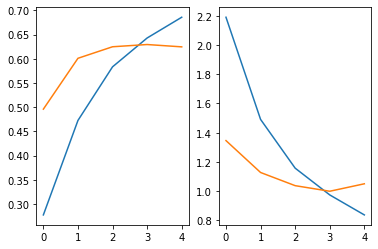

In [ ]:
plt.subplot(1,2,1)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.show()

In [ ]:
pre = model.predict(x_test3)

In [ ]:
pree = np.argmax(pre, axis=1)
set(pree)

{0, 1, 2, 4, 5}

In [ ]:
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
sub['target'] = pree

In [ ]:
sub.to_csv('submission.csv', index=False)

## tf(train1)(fail...)

In [ ]:
x_train1_re = x_train1.toarray()

In [ ]:
x_train1_re.shape

(25000, 5000)

In [ ]:
np.max(x_train1_re)

14

In [ ]:
def model_make4():
    inputs = layers.Input(shape=(5000))
    x = layers.Embedding(input_dim=14 , output_dim=128, input_length=5000)(inputs)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation='softmax')(x) 

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = model_make4()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 embedding (Embedding)       (None, 5000, 128)         1792      
                                                                 
 bidirectional (Bidirectiona  (None, 5000, 256)        263168    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5000, 256)        1024      
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(x_train1_re, y_train1, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 292s 453ms/step - loss: 2.3741 - accuracy: 0.2289 - val_loss: 8.8145 - val_accuracy: 0.0034
Epoch 2/10
625/625 [==============================] - 277s 443ms/step - loss: 2.0634 - accuracy: 0.2761 - val_loss: 1.8709 - val_accuracy: 0.4002
Epoch 3/10
625/625 [==============================] - 278s 444ms/step - loss: 1.8954 - accuracy: 0.3114 - val_loss: 1.9413 - val_accuracy: 0.1776
Epoch 4/10
625/625 [==============================] - 278s 445ms/step - loss: 1.7736 - accuracy: 0.3327 - val_loss: 1.8264 - val_accuracy: 0.1560
Epoch 5/10
625/625 [==============================] - 278s 444ms/step - loss: 1.6744 - accuracy: 0.3437 - val_loss: 1.4492 - val_accuracy: 0.3294
Epoch 6/10
625/625 [==============================] - 277s 443ms/step - loss: 1.5921 - accuracy: 0.3571 - val_loss: 1.5833 - val_accuracy: 0.1958
Epoch 7/10
625/625 [==============================] - 278s 445ms/step - loss: 1.5338 - accuracy: 0.3632 - val_loss: 2.6184 -

KeyboardInterrupt: ignored

## tf(train3 + FastText)(fail)


In [66]:
train_tk

,id,reviews,target,reviews_ck,reviews_tk,reviews_lb
0,0,조아요 처음구입 싸게햇어요,2,좋아요 처음 구입 싸게 했어요,"[좋아요, 처음, 구입, 싸게, 했어요]","[4, 76, 58, 382, 36]"
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천 원가량 주고 사기 너무...,"[생각, 잘, 돼요, 매지, 바른지, 하루, 됐는데, 가량, 주고, 사기, 아깝네요]","[13, 1, 230, 8950, 12753, 208, 918, 2994, 293,..."
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...,"[디자인, 괜찮은데, 상품, 금, 가서, 교환, 했는데, 두, 받은, 상품, 까져있...","[74, 601, 34, 1117, 332, 100, 11, 57, 588, 34,..."
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다 ...,"[기전, 이, 제품, 이마트, 트, 레이더스, 팔던, 프리미엄, 제품, 사용, 했었...","[7134, 49, 12, 2813, 1056, 5973, 7135, 2995, 1..."
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,튼튼하고 손목을 잘 받쳐주네요,"[튼튼하고, 손목, 잘, 받쳐주네요]","[296, 1951, 1, 12758]"
...,...,...,...,...,...,...
24995,24995,일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여,5,일단 향이 너무너무 좋은데 지 속력만 좋다면 좋겠지만 워낙 저렴해 그래도 좋아요,"[일단, 향, 좋은데, 지, 속력, 좋다면, 좋겠지만, 워낙, 저렴해, 좋아요]","[168, 90, 174, 617, 26625, 26626, 6814, 1064, ..."
24996,24996,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.,2,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다,"[동일한, 업체, 발송, 한, 상자, 배송, 되었는데, 택배, 비는, 이중, 처리,...","[3872, 745, 823, 28, 610, 2, 1948, 120, 7348, ..."
24997,24997,향이 좋아요!! 다른 향도 시켜보고 싶어요,4,향이 좋아요 다른 향도 시켜보고 싶어요,"[향, 좋아요, 다른, 향, 시켜, 보고, 싶어요]","[90, 4, 33, 90, 265, 71, 698]"
24998,24998,펼쳐보니 끝부분쯤에 50cm정도 찟어져 있습니다 날짜관계로 구냥 사용합니다,2,펼쳐보니 끝부분쯤에 50cm 정도 찢어져 있습니다 날짜 관계로 구냥 사용합니다,"[펼쳐, 보니, 끝, 부분, 정도, 찢어져, 있습니다, 날짜, 관계, 구, 사용, ...","[6097, 128, 384, 37, 45, 2573, 91, 1362, 5232,..."


In [67]:
# 하이퍼파라미터
num_features = 1000 # word2vec 특징 수
min_word_count =20 
num_workers = 6
context =10 # Word2vec 수행을 위한 컨텍스트 윈도 크기
# https://medium.com/@omicro03/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-13%EC%9D%BC%EC%B0%A8-word2vec-3c82ec870426
downsampling = 1e-3 #Word2vec 빠른 학습을 위해 정답 단어 라벨에 대한 다운 샘플링, 보통 0.001이 좋은 성능
#Downsampling of frequent words # 자주 나오는 단어에 대해서는 0.001 만큼 다운 샘플링하여 시간을 아낌

In [68]:
model_ft = gensim.models.FastText(train_tk['reviews_tk'],
                          workers = num_workers,
                          size = num_features,
                          min_count = min_word_count,
                          window =  context,
                          sample = downsampling,
                          iter = 10,
                          sg =0 # sg =0 CBOW, 1 : skip-gram
                         )

In [69]:
len(set(model_ft.wv.index2word))+1

1951

In [70]:
model_ft.wv.most_similar('좋다')

[('주변', 0.9432312250137329),
 ('들', 0.9336134791374207),
 ('좋다고', 0.9250473380088806),
 ('먹으려고', 0.8840985298156738),
 ('어머니', 0.8829615712165833),
 ('지인', 0.882790207862854),
 ('남편', 0.8802388906478882),
 ('검색', 0.8780465126037598),
 ('신랑', 0.8731937408447266),
 ('워낙', 0.8723360896110535)]

In [71]:
def get_features(words, model, num_features):
    feature_vector = np.zeros((num_features), dtype = np.float32)
    
    num_words = 0
    # 어휘 사전
    index2word_set = set(model.wv.index2word)
    
    for w in words:
        if w in index2word_set:
            num_words +=1
            #사전에 해당하는 단어에 대해 단어 벡터를 더함
            
            feature_vector = np.add(feature_vector, model[w])
            # model은 단어들에 대한 vector를 다 가지고 있음
            # num_features 만큼 이미 학습할때 정의해서 만들어놓음 
            
    feature_vector = np.divide(feature_vector,num_words)
    
    return feature_vector

def get_dataset(reviews, model, num_features):
    dataset = list()

    
    for s in reviews :
        dataset.append(get_features(s,model,num_features))
    
    reviewFeaturevecs = np.stack(dataset)
    
    return reviewFeaturevecs

x_train3 = get_dataset(train_tk['reviews_tk'],model_ft,num_features)
x_test3 = get_dataset(test_tk['reviews_tk'],model_ft,num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [72]:
y_train3_re = pd.get_dummies(y_train3.astype('str'))

In [74]:
x_train3.shape, x_test3.shape, y_train3.shape

((25000, 1000), (25000, 1000), (25000,))

In [ ]:
x_train3[0].shape

(1000,)

In [96]:
def model_make4():
    inputs = layers.Input(shape=(1000))
    x = layers.Embedding(input_dim=1951, output_dim=128, input_length=1000)(inputs)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
    # x = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
    # x = layers.Bidirectional(layers.LSTM(128))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4,activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [97]:
model = model_make4()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_7 (Embedding)     (None, 1000, 128)         249728    
                                                                 
 bidirectional_11 (Bidirecti  (None, 1000, 256)        263168    
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 256000)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               32768128  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                           

In [100]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [101]:
his = model.fit(x_train3, y_train3_re, epochs=5, validation_split=0.2)

Epoch 1/5
  2/625 [..............................] - ETA: 23:59 - loss: 3.6714 - accuracy: 0.3281  

InvalidArgumentError: ignored

## tf(train3+ FastText(weight))

In [15]:
y_train3_re = pd.get_dummies(y_train3.astype('str'))

In [16]:
y_train3_re

,1,2,4,5
0,0,1,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,1
...,...,...,...,...
24995,0,0,0,1
24996,0,1,0,0
24997,0,0,1,0
24998,0,1,0,0


In [17]:
model_ft = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/kaggle/wiki.ko.vec', binary=False)

In [ ]:
model_ft.vectors.shape

(879129, 300)

In [18]:
embadding_matrix = np.zeros((word_size, 300))
embadding_matrix.shape

(26628, 300)

In [19]:
def get_vector(x):
    if x in model_ft:
        return model_ft[x]
    else:
        return None

for x, i in tokenizer.word_index.items():
    # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다 
    temp = get_vector(x)
    #단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None:
        # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embadding_matrix[i] = temp
        # 해당 단어 위치의 행에 벡터의 값을 저장한다.

In [20]:
maxlen = 25
input_dim = 26628
def model_make4():
    inputs = layers.Input(shape = maxlen)
    x = layers.Embedding(input_dim=input_dim,output_dim=300, weights=[embadding_matrix],input_length=maxlen, trainable=False)(inputs)
    x = layers.Bidirectional(layers.LSTM(300, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(300, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(300))(x)
    x = layers.Flatten()(x)
    #x = layers.GlobalMaxPool1D()(x)
    # x = layers.Dense(32, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    # x = layers.Dense(300, activation='relu')(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.Dense(128, activation='relu')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4,activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [29]:
model = model_make4()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 25, 300)           7988400   
                                                                 
 bidirectional_3 (Bidirectio  (None, 25, 600)          1442400   
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 25, 600)          2162400   
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 600)              2162400   
 nal)                                                            
                                                           

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [31]:
his = model.fit(x_train3, y_train3_re, epochs=5, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 630s 994ms/step - loss: 1.0506 - accuracy: 0.5667 - val_loss: 0.9348 - val_accuracy: 0.6076
Epoch 2/5
625/625 [==============================] - 622s 994ms/step - loss: 0.9486 - accuracy: 0.6094 - val_loss: 0.8995 - val_accuracy: 0.6332
Epoch 3/5
625/625 [==============================] - 629s 1s/step - loss: 0.8950 - accuracy: 0.6294 - val_loss: 0.8740 - val_accuracy: 0.6362
Epoch 4/5
625/625 [==============================] - 636s 1s/step - loss: 0.8533 - accuracy: 0.6442 - val_loss: 0.8772 - val_accuracy: 0.6460
Epoch 5/5
625/625 [==============================] - 668s 1s/step - loss: 0.8151 - accuracy: 0.6568 - val_loss: 0.8719 - val_accuracy: 0.6372


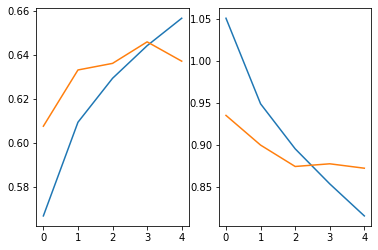

In [33]:
plt.subplot(1,2,1)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.show()

In [34]:
pre = model.predict(x_test3)

In [35]:
pre

array([[0.11883478, 0.6015976 , 0.13436544, 0.14520222],
       [0.5316374 , 0.45729384, 0.00277326, 0.00829547],
       [0.02087362, 0.05056918, 0.18520954, 0.74334764],
       ...,
       [0.4961942 , 0.48694557, 0.00338303, 0.01347719],
       [0.01713017, 0.04139559, 0.14422919, 0.7972451 ],
       [0.18292901, 0.5771334 , 0.11755036, 0.12238722]], dtype=float32)

In [38]:
y_train3_re.columns[0]

'1'

In [44]:
pree = np.argmax(pre, axis=1)
pree

array([1, 0, 3, ..., 0, 3, 1])

In [ ]:
pref = []
for i in pree:
    pref.append(y_train3_re.columns[i])
pref

In [58]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['target'] = pref

In [61]:
sub['target'] = sub['target'].astype('int64')

In [65]:
sub.to_csv('submission.csv', index=False)